## Import Packages

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

## Load in Data

In [2]:
df = pd.read_csv("./nbaplayersdraft.csv")

In [3]:
df.head()

,id,year,rank,overall_pick,team,player,college,years_active,games,minutes_played,...,3_point_percentage,free_throw_percentage,average_minutes_played,points_per_game,average_total_rebounds,average_assists,win_shares,win_shares_per_48_minutes,box_plus_minus,value_over_replacement
0,1,1989,1,1,SAC,Pervis Ellison,Louisville,11.0,474.0,11593.0,...,0.050,0.689,24.5,9.5,6.7,1.5,21.8,0.090,-0.5,4.4
1,2,1989,2,2,LAC,Danny Ferry,Duke,13.0,917.0,18133.0,...,0.393,0.840,19.8,7.0,2.8,1.3,34.8,0.092,-0.9,4.9
2,3,1989,3,3,SAS,Sean Elliott,Arizona,12.0,742.0,24502.0,...,0.375,0.799,33.0,14.2,4.3,2.6,55.7,0.109,0.2,13.5
3,4,1989,4,4,MIA,Glen Rice,Michigan,15.0,1000.0,34985.0,...,0.400,0.846,35.0,18.3,4.4,2.1,88.7,0.122,0.8,24.9
4,5,1989,5,5,CHH,J.R. Reid,UNC,11.0,672.0,15370.0,...,0.135,0.716,22.9,8.5,5.0,1.0,22.5,0.070,-2.9,-3.7


## Part 1: Data Comprehension

### Question 1: Which NBA team(s) has drafted the most players who went to Duke and were drafted in or before the 2000 draft?

In [19]:
# Find the players who were drafted by Duke and were drafted on or before the year 2000
duke_df = df.loc[(df.college == "Duke") & (df.year <= 2000),]

In [30]:
# Group by team and find the number of rows associated with each team which is the number of players
# drafted that meet the above criteria. 
duke_df.groupby(by = "team").size().sort_values(ascending = False)

team
DAL    2
MIN    2
PHO    2
ATL    1
CHI    1
CLE    1
DET    1
HOU    1
IND    1
LAC    1
POR    1
SAC    1
SAS    1
SEA    1
dtype: int64

**Dallas, Minnesota, and Phoenix each drafted two players from Duke before 2000**

### Question 2: Which NBA team(s) has drafted the most players who have a first name that begins with D and were drafted in an even year draft (1990, 1992, 1994, ...)?

In [25]:
# Find the players whose name starts with D and were drafted in an even year
d_df = df.loc[(df.player.str.startswith("D")) & (df.year % 2 == 0),]

In [32]:
# Same process as above, find the number of players for each team meeting the criteria
d_df.groupby(by = "team").size().sort_values(ascending = False)

team
MIL    7
BOS    7
SEA    7
ATL    6
ORL    5
MIA    5
SAS    5
LAL    4
DAL    4
DEN    4
NYK    4
CHI    4
PHO    3
CLE    3
DET    3
GSW    3
UTA    3
LAC    3
MEM    3
SAC    3
CHH    2
POR    2
TOR    2
PHI    2
NJN    2
NOP    2
NOH    2
MIN    2
IND    2
WAS    2
OKC    1
CHA    1
BRK    1
HOU    1
dtype: int64

**Milwaukee, Boston, and Seattle all drafted 7 players whose name started with a letter D in an even year. If you want to count franchises who meet the above criteria, Seattle/OKC drafted 8 players whose name started with D in an even year.**

### Question 3: Describe the relationship between a team’s first round pick slot in one year with their first-round pick slot in the subsequent year.

In [57]:
df_first_round = df.loc[((df.year <= 1995) & (df.overall_pick <= 27)) |
                        ((df.year > 1995) & (df.year <= 2004) & (df.overall_pick <= 29)) |
                        ((df.year > 2004) & (df.overall_pick <= 30)),]

In [58]:
grouped_first_picks = df_first_round.groupby(by = ["team","year"])[["overall_pick"]].first()

In [75]:
team_pick_delta = grouped_first_picks.groupby("team")["overall_pick"].mean()
print(team_pick_delta)

team
ATL    13.758621
BOS    14.275862
BRK    23.571429
CHA     6.000000
CHH    11.083333
CHI    14.633333
CHO    11.285714
CLE    11.125000
DAL    13.400000
DEN    13.692308
DET    14.259259
GSW    12.620690
HOU    15.900000
IND    17.185185
LAC    10.615385
LAL    18.583333
MEM    12.562500
MIA    14.900000
MIL    11.740741
MIN     8.222222
NJN    12.500000
NOH    13.250000
NOK    12.500000
NOP     7.500000
NYK    14.173913
OKC    17.545455
ORL    12.103448
PHI    11.214286
PHO    15.250000
POR    17.259259
SAC    10.500000
SAS    22.560000
SEA    14.777778
TOR    11.391304
UTA    18.714286
VAN     3.166667
WAS     9.764706
WSB     8.166667
Name: overall_pick, dtype: float64


In [76]:
team_pick_delta.mean()

13.204017970525035

**I calculated the mean difference in first round pick slots for each team and then the mean difference in first round pick slots overall and found that the mean pick difference was ~13 slots lower in a subsequent year. For team-specific information, please check the output above.**

## Part 2: Analytical Acumen

### Overarching Question: Analyze draft position value and team success/deficiencies compared to expectation.

### Part 1: Create a method for valuing each draft slot in the NBA Draft (picks 1 through 60 in most drafts).

In [78]:
df.columns

Index(['id', 'year', 'rank', 'overall_pick', 'team', 'player', 'college',
       'years_active', 'games', 'minutes_played', 'points', 'total_rebounds',
       'assists', 'field_goal_percentage', '3_point_percentage',
       'free_throw_percentage', 'average_minutes_played', 'points_per_game',
       'average_total_rebounds', 'average_assists', 'win_shares',
       'win_shares_per_48_minutes', 'box_plus_minus',
       'value_over_replacement'],
      dtype='object')

**Use the following metrics for evaluating the value of picks:**
 - Points
 - Total rebounds
 - Assists
 - Win shares
 - Box plus minus
 - Value over replacement

**The intent here is to create a holistic evaluation of a player's overall contribution in the league which is why I am using the total values instead of per game averages.**

In [79]:
valuation_metrics = ['points', 
                     'total_rebounds',
                     'assists',
                     'win_shares',
                     'box_plus_minus',
                     'value_over_replacement']

valuation_data = df[valuation_metrics]

**To ensure one columns arbitrarily high value (such as points) doesn't overtake the evaluation metric, I chose to use a standard scaler and apply it to the above columns. This will allow us to look at players who are outliers in both positive and negative directions.**

In [85]:
sc = StandardScaler()
scaled_data = sc.fit_transform(valuation_data)

valuation_df = pd.concat([df["overall_pick"], pd.DataFrame(scaled_data,columns = valuation_metrics)], axis = 1)

**Calculate the expected value of each pick by taking the mean across each standarized evaluation metric. Future analysis would likely use weights to more heavily favor certain metrics (such as VORP). Interestingly enough, the order of value of each pick is not strictly descending which in the context of this analysis I am deeming fine. There is a lot of variance in NBA performance based on draft slot so I think capturing that variance by not having a strictly descending value of picks is actually good.**

In [148]:
grouped_valuation = valuation_df.groupby(by = "overall_pick").mean()
pick_expected_value = grouped_valuation.mean(axis = 1)
pick_expected_value

overall_pick
1     1.410424
2     0.919785
3     1.168356
4     0.974921
5     0.918132
6     0.188535
7     0.497359
8     0.202828
9     0.637954
10    0.537894
11    0.179891
12    0.055357
13    0.314092
14    0.021985
15    0.161904
16   -0.006536
17    0.104614
18   -0.008852
19   -0.069406
20   -0.177279
21    0.091938
22   -0.177684
23   -0.043595
24    0.126565
25   -0.164035
26   -0.030555
27   -0.065116
28   -0.130317
29   -0.185896
30   -0.150226
31   -0.314271
32   -0.324010
33   -0.380061
34   -0.337729
35   -0.179870
36   -0.279293
37   -0.333998
38   -0.293333
39   -0.373690
40   -0.316585
41   -0.302304
42   -0.274102
43   -0.330916
44   -0.380679
45   -0.117673
46   -0.326519
47   -0.183547
48   -0.382653
49   -0.456915
50   -0.452096
51   -0.477780
52   -0.523210
53   -0.507163
54   -0.474064
55   -0.602084
56   -0.328199
57   -0.186433
58   -0.520341
59   -0.718956
60   -0.453820
dtype: float64

In [153]:
total_df = pd.concat([df["team"], df["college"], valuation_df], axis = 1)
total_df.head(10)

,team,college,overall_pick,points,total_rebounds,assists,win_shares,box_plus_minus,value_over_replacement
0,SAC,Louisville,1,0.189356,0.835206,-0.064865,0.140318,0.437277,-0.000277
1,LAC,Duke,2,0.592490,0.525684,0.319805,0.604912,0.340709,0.043359
2,SAS,Arizona,3,1.443321,0.852180,0.874228,1.351837,0.606271,0.793907
3,MIA,Michigan,4,3.058345,1.442769,1.029965,2.531191,0.751123,1.788820
4,CHH,UNC,5,0.435175,0.940544,-0.105357,0.165335,-0.142131,-0.707189
5,CHI,Oklahoma,6,-0.157816,-0.018476,-0.301585,-0.249226,-0.262841,-0.619916
6,IND,Florida State,7,0.693222,0.421844,0.774556,0.240385,0.364851,0.078269
7,DAL,Louisiana Tech,8,-0.310364,-0.065404,-0.466666,-0.570868,-0.649113,-0.733371
8,WSB,Georgia Tech,9,0.007583,0.372421,-0.308593,-0.113422,-0.359409,-0.794462
9,MIN,UCLA,10,0.725970,0.154756,2.651963,0.315434,0.606271,0.532088


In [154]:
total_df["pick_value"] = valuation_df.iloc[:,2:].mean(axis = 1)
total_df.head(10)

,team,college,overall_pick,points,total_rebounds,assists,win_shares,box_plus_minus,value_over_replacement,pick_value
0,SAC,Louisville,1,0.189356,0.835206,-0.064865,0.140318,0.437277,-0.000277,0.269532
1,LAC,Duke,2,0.592490,0.525684,0.319805,0.604912,0.340709,0.043359,0.366894
2,SAS,Arizona,3,1.443321,0.852180,0.874228,1.351837,0.606271,0.793907,0.895685
3,MIA,Michigan,4,3.058345,1.442769,1.029965,2.531191,0.751123,1.788820,1.508773
4,CHH,UNC,5,0.435175,0.940544,-0.105357,0.165335,-0.142131,-0.707189,0.030241
5,CHI,Oklahoma,6,-0.157816,-0.018476,-0.301585,-0.249226,-0.262841,-0.619916,-0.290409
6,IND,Florida State,7,0.693222,0.421844,0.774556,0.240385,0.364851,0.078269,0.375981
7,DAL,Louisiana Tech,8,-0.310364,-0.065404,-0.466666,-0.570868,-0.649113,-0.733371,-0.497084
8,WSB,Georgia Tech,9,0.007583,0.372421,-0.308593,-0.113422,-0.359409,-0.794462,-0.240693
9,MIN,UCLA,10,0.725970,0.154756,2.651963,0.315434,0.606271,0.532088,0.852103


In [156]:
total_df["expected_vs_value"] = 0
for ii, value in enumerate(pick_expected_value):
    total_df.loc[total_df["overall_pick"] == (ii + 1), "expected_vs_value"] = total_df.loc[total_df["overall_pick"] == (ii + 1), "pick_value"] - value

In [157]:
total_df.head(10)

,team,college,overall_pick,points,total_rebounds,assists,win_shares,box_plus_minus,value_over_replacement,pick_value,expected_vs_value
0,SAC,Louisville,1,0.189356,0.835206,-0.064865,0.140318,0.437277,-0.000277,0.269532,-1.140892
1,LAC,Duke,2,0.592490,0.525684,0.319805,0.604912,0.340709,0.043359,0.366894,-0.552891
2,SAS,Arizona,3,1.443321,0.852180,0.874228,1.351837,0.606271,0.793907,0.895685,-0.272671
3,MIA,Michigan,4,3.058345,1.442769,1.029965,2.531191,0.751123,1.788820,1.508773,0.533852
4,CHH,UNC,5,0.435175,0.940544,-0.105357,0.165335,-0.142131,-0.707189,0.030241,-0.887891
5,CHI,Oklahoma,6,-0.157816,-0.018476,-0.301585,-0.249226,-0.262841,-0.619916,-0.290409,-0.478943
6,IND,Florida State,7,0.693222,0.421844,0.774556,0.240385,0.364851,0.078269,0.375981,-0.121378
7,DAL,Louisiana Tech,8,-0.310364,-0.065404,-0.466666,-0.570868,-0.649113,-0.733371,-0.497084,-0.699912
8,WSB,Georgia Tech,9,0.007583,0.372421,-0.308593,-0.113422,-0.359409,-0.794462,-0.240693,-0.878646
9,MIN,UCLA,10,0.725970,0.154756,2.651963,0.315434,0.606271,0.532088,0.852103,0.314209


In [116]:
team_draft_performance = total_df.groupby(by = "team")["expected_vs_value"].mean()
college_draft_performance = total_df.groupby(by = "college")["expected_vs_value"].mean()

team
NOH    0.612756
SEA    0.394700
SAS    0.284841
CHH    0.137536
LAL    0.097827
CLE    0.094208
IND    0.091787
DEN    0.089202
HOU    0.084226
TOR    0.083729
MIL    0.061088
GSW    0.058712
WSB    0.058393
DET    0.017432
PHO    0.002514
MEM    0.001310
UTA   -0.003950
MIA   -0.011283
BOS   -0.017306
OKC   -0.035888
MIN   -0.042969
VAN   -0.050669
PHI   -0.055415
SAC   -0.062090
NJN   -0.062163
BRK   -0.062595
CHI   -0.066586
POR   -0.070836
CHA   -0.080177
ORL   -0.089665
LAC   -0.098564
ATL   -0.107338
NYK   -0.119751
DAL   -0.121430
WAS   -0.151234
CHO   -0.325151
NOP   -0.397945
NOK   -0.537559
Name: expected_vs_value, dtype: float64

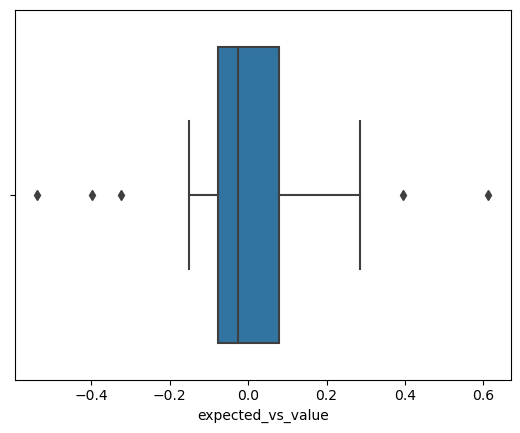

In [147]:
boxplot = sns.boxplot(x = team_draft_performance)
team_draft_performance.sort_values(ascending = False)

college
Santa Clara                        3.251134
Davidson                           2.651409
Trinity Valley CC                  1.794894
Rhode Island                       1.421734
Butler County Community College    1.276696
                                     ...   
UNC Charlotte                     -0.783872
Loyola Marymount                  -0.829251
Barton County Community College   -0.951742
Toledo                            -1.293027
University of the Pacific         -1.661158
Name: expected_vs_value, Length: 219, dtype: float64

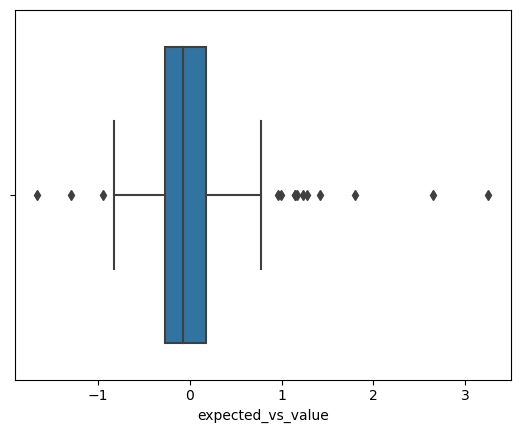

In [146]:
boxplot = sns.boxplot(x = college_draft_performance)
college_draft_performance.dropna().sort_values(ascending = False)